<a href="https://colab.research.google.com/github/Jessica1842553/MCDaa2025/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tarea 5 - Jessica Lizeth Hernández Bracho 1842553
### **Agrupamiento**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/student-mat.csv', sep=";")

In [3]:
# Modificando columnas - convertir 'yes'/'no' a 1/0
df['higher'] = df['higher'].map({'yes': 1, 'no': 0})

In [4]:
#Variables de Interés a analizar
x = df[['age',
       'studytime',
       'failures',
       'absences',
        'higher',
       'G1',
       'G2']]

y = df['G3']

In [5]:
x.head()

,age,studytime,failures,absences,higher,G1,G2
0,18,2,0,6,1,5,6
1,17,2,0,4,1,5,5
2,15,2,3,10,1,7,8
3,15,3,0,2,1,15,14
4,16,2,0,4,1,6,10


In [6]:
y.head()

,G3
0,6
1,6
2,10
3,15
4,10


In [7]:
# DataFrame con las variables seleccionadas y nota final G3
varint_columns = x.columns.tolist() + [y.name]
df_varin = df[varint_columns].copy()

display(df_varin.head())

,age,studytime,failures,absences,higher,G1,G2,G3
0,18,2,0,6,1,5,6,6
1,17,2,0,4,1,5,5,6
2,15,2,3,10,1,7,8,10
3,15,3,0,2,1,15,14,15
4,16,2,0,4,1,6,10,10


In [8]:
from sklearn.preprocessing import StandardScaler

# Escalar variables numéricas
scaler = StandardScaler()
X = scaler.fit_transform(x)

###  Algoritmo no supervisado: **DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad.   

Agrupa puntos que están suficientemente cerca unos de otros (según una distancia *eps*) y que forman regiones densamente pobladas (al menos *min_samples* puntos). Los puntos que no cumplen esta condición se consideran "ruido" o outliers.

### Métrica: **Silhouette Score**

Esta métrica compara la cohesión interna de los clusters (qué tan cerca están los puntos dentro del mismo cluster) con la separación entre clusters distintos.  
Su valor varía entre -1 y 1; valores cercanos a 1 indican buenos agrupamientos.

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

#Lista de valores de eps (radio de vecindad) y min_samples (mínimo de puntos para formar un núcleo).
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cl_db = dbscan.fit_predict(X)

    n_clusters = len(set(cl_db)) - (1 if -1 in cl_db else 0)
    n_outliers = list(cl_db).count(-1)

    print(f"\neps = {eps} → Clusters encontrados: {n_clusters}, Outliers: {n_outliers}")

    if n_clusters > 1:
        score = silhouette_score(X, cl_db)
        print(f"Silhouette Score: {score:.3f}")
    else:
        print("No se puede calcular Silhouette Score (menos de 2 clusters)")


eps = 0.5 → Clusters encontrados: 9, Outliers: 306
Silhouette Score: -0.248

eps = 1.0 → Clusters encontrados: 4, Outliers: 143
Silhouette Score: 0.020

eps = 1.5 → Clusters encontrados: 2, Outliers: 58
Silhouette Score: 0.339

eps = 2.0 → Clusters encontrados: 2, Outliers: 13
Silhouette Score: 0.468


In [10]:
# Aplicar DBSCAN con eps=2.0 (mejores resultados)
dbscan = DBSCAN(eps=2.0, min_samples=5)
db_cls = dbscan.fit_predict(X)

# Etiquetas al DataFrame
df_varin['dbscan_cluster'] = db_cls

# Registros por cluster
print(df_varin['dbscan_cluster'].value_counts())

# Promedios por cluster (incluyendo G3)
print("\nPromedios por cluster (DBSCAN):")
print(df_varin.groupby('dbscan_cluster').mean())

dbscan_cluster
 0    368
 1     14
-1     13
Name: count, dtype: int64

Promedios por cluster (DBSCAN):
                      age  studytime  failures   absences    higher  \
dbscan_cluster                                                        
-1              18.076923   1.769231  1.000000  26.461538  0.538462   
 0              16.614130   2.073370  0.266304   5.127717  1.000000   
 1              17.571429   1.285714  1.500000   1.714286  0.000000   

                       G1         G2         G3  
dbscan_cluster                                   
-1              10.923077   9.153846   9.000000  
 0              11.035326  10.894022  10.638587  
 1               7.571429   7.428571   5.857143  


#### **Resumen de resultados por cluster (DBSCAN)**

DBSCAN identificó tres grupos:

- Cluster 0 (368 estudiantes): Estudiantes con buen rendimiento *(G3 - Nota final ≈ 10.6)*, pocas fallas, pocas ausencias y alto interés en continuar estudios superiores. Representan el grupo más regular o exitoso.

- Cluster 1 (14 estudiantes): Estudiantes con bajo rendimiento (G3 ≈ 5.9), más materias reprobadas y sin interés en educación superior. Podrían estar en riesgo académico.

- Cluster -1 (13 estudiantes, outliers): Estudiantes con muchas ausencias *(Absences ≈ 26)* y rendimiento medio. Su perfil es distinto del resto, posiblemente por factores externos que afectan el desempeño escolar.

### Boxplot de Nota final - G3 por cluster

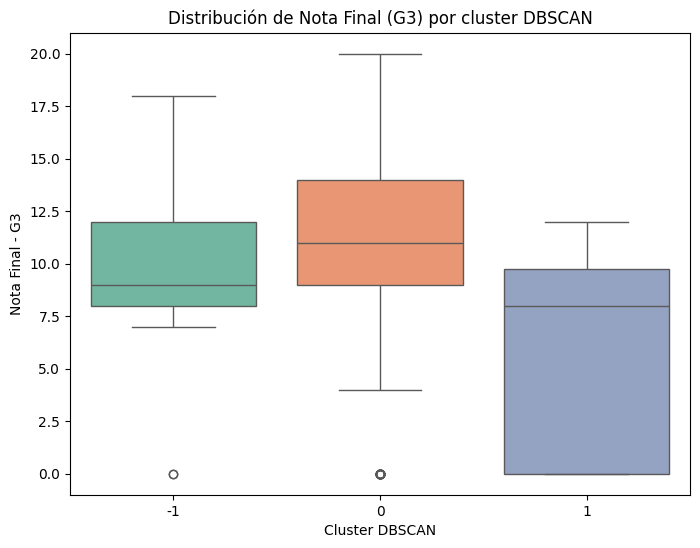

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(x='dbscan_cluster', y='G3', data=df_varin, hue='dbscan_cluster', palette='Set2', legend=False)
plt.title('Distribución de Nota Final (G3) por cluster DBSCAN')
plt.xlabel('Cluster DBSCAN')
plt.ylabel('Nota Final - G3')
plt.show()

El gráfico confirma que los grupos formados por DBSCAN reflejan diferencias claras en el rendimiento académico.  

El cluster 0 agrupa a los estudiantes con mejores notas, mientras que el cluster 1 representa un grupo con desempeño muy bajo.  
Los outliers (cluster -1) tienen un comportamiento mixto, pero diferente al resto, especialmente por las ausencias.